# Project Sidewalk - get crossing features

In [1]:
import json
import requests
import functions as f

import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame

import matplotlib.pyplot as plt

import seaborn as sns
import folium

import config_azure as cf

In [2]:
os.system('sudo blobfuse /home/azureuser/cloudfiles/code/blobfuse/sidewalk --tmp-path=/mnt/resource/blobfusetmp --config-file=/home/azureuser/cloudfiles/code/blobfuse/fuse_connection_sidewalk.cfg -o attr_timeout=3600 -o entry_timeout=3600 -o negative_timeout=3600 -o allow_other -o nonempty')

0

### Settings

In [3]:
CRS = 'epsg:28992'

## 1. Get project sidewalk data

### Get the correct url for a small test neighborhood or the whole city

In [4]:
base_url = "https://sidewalk-amsterdam.cs.washington.edu/v2/access/attributesWithLabels?lat1={}&lng1={}&lat2={}&lng2={}" 
amsterdam_bbox_coords = (52.303, 4.8, 52.425, 5.05)
url = base_url.format(*amsterdam_bbox_coords)

### Try to read the data from local dump if available else go to the Project Sidewalk API

In [5]:
local_dump = url.replace('/', '|')

try:
    project_sidewalk_labels = json.load(open(local_dump, 'r'))
except Exception as e:
    print("Couldn't load local dump")
    project_sidewalk_labels = requests.get(url.format(*amsterdam_bbox_coords)).json()
    json.dump(project_sidewalk_labels, open(local_dump, 'w'))

### Create sidewalk data geodataframe

In [6]:
p_sw_gdf = gpd.GeoDataFrame.from_features(project_sidewalk_labels['features'], crs='epsg:4326')
p_sw_gdf = p_sw_gdf.to_crs(CRS)
p_sw_gdf

,geometry,attribute_id,label_type,street_edge_id,osm_street_id,neighborhood,severity,is_temporary,label_id,gsv_panorama_id,...,image_capture_date,label_date,label_severity,label_is_temporary,agree_count,disagree_count,notsure_count,label_tags,label_description,user_id
0,POINT (124624.891 490749.871),343216,CurbRamp,1840,7041627,Buikslotermeer Noord,2.0,False,59,uYC_xEEHepfHPReXw5AHew,...,2019-06,2022-01-13 13:52:40.892,2.0,False,8,1,0,[],None,78391ab2-8531-4483-b2d6-af0bac7c76c1
1,POINT (124613.110 490744.426),341369,CurbRamp,1840,7041627,De Kleine Wereld,2.0,False,66,CxTLkzJMV9MTTlTF17X36w,...,2019-06,2022-01-13 16:48:32.487,NaN,False,8,0,0,[],None,78391ab2-8531-4483-b2d6-af0bac7c76c1
2,POINT (124545.514 490775.828),341358,CurbRamp,27961,547523663,De Kleine Wereld,2.0,False,64,ihBHBSu6Lwr876Cu-JmdCQ,...,2019-06,2022-01-13 13:53:43.971,NaN,False,8,0,0,[missing tactile warning],None,78391ab2-8531-4483-b2d6-af0bac7c76c1
3,POINT (124535.524 490781.832),343220,CurbRamp,2219,7042392,Buikslotermeer Noord,2.0,False,65,ihBHBSu6Lwr876Cu-JmdCQ,...,2019-06,2022-01-13 13:53:53.332,4.0,False,9,0,1,[missing tactile warning],None,78391ab2-8531-4483-b2d6-af0bac7c76c1
4,POINT (124571.559 490784.156),343206,CurbRamp,1840,7041627,Buikslotermeer Noord,2.0,False,61,vwuKEbqFRUi785LzDF4X0g,...,2019-06,2022-01-13 13:53:11.583,2.0,False,8,0,0,[],None,78391ab2-8531-4483-b2d6-af0bac7c76c1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10791,POINT (127332.892 486225.835),361564,CurbRamp,18768,43996053,Steigereiland Noord,1.0,False,31677,0dYwJ4nh6mmYy4T42eafYA,...,2020-06,2023-11-09 00:13:14.742,1.0,False,0,0,0,[],None,4fe6a68f-99da-414e-a615-030d5e685bee
10792,POINT (127326.572 486222.475),361569,Obstacle,18767,43996053,Steigereiland Noord,3.0,False,31684,0dYwJ4nh6mmYy4T42eafYA,...,2020-06,2023-11-09 00:14:58.486,3.0,False,0,0,0,[sign],None,4fe6a68f-99da-414e-a615-030d5e685bee
10793,POINT (127316.951 486221.256),361570,Obstacle,30328,712481604,Steigereiland Noord,3.0,False,31683,0dYwJ4nh6mmYy4T42eafYA,...,2020-06,2023-11-09 00:14:39.171,3.0,False,0,0,0,[pole],None,4fe6a68f-99da-414e-a615-030d5e685bee
10794,POINT (127371.491 486187.419),361571,Obstacle,21087,148619066,Steigereiland Noord,5.0,False,31685,elRl_7in8CQjaMrCgaofLA,...,2020-06,2023-11-09 00:16:20.835,5.0,False,0,0,0,[pole],None,4fe6a68f-99da-414e-a615-030d5e685bee


### Get mask of area

200


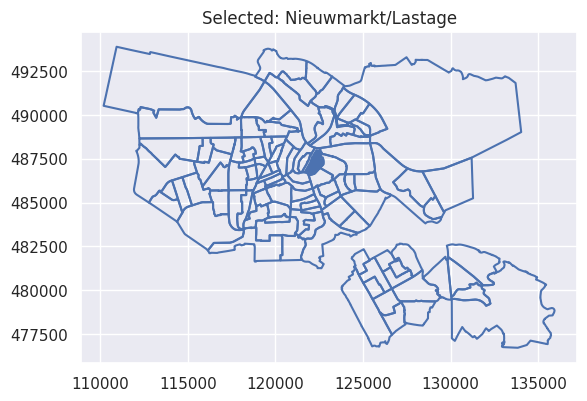

In [7]:
# Pull polygon of area for which to gather curb segments

# Select area granularity (buurten/wijken/ggwgebieden/stadsdelen, https://api.data.amsterdam.nl/v1/docs/datasets/gebieden.html)
area_granularity = 'wijken'

# SELECT AREA
district_name = 'Centrum'
my_area = 'Nieuwmarkt/Lastage'
# district_name = 'Nieuw-West'
# my_area = 'Osdorp-Midden'

# Get area data
area_url = "https://api.data.amsterdam.nl/v1/gebieden/" + area_granularity
response_area = requests.get(url = area_url, params = {"_pageSize": 1000})
raw_data_area = response_area.json()['_embedded']
print(response_area.status_code)

# Create a proper GeoDataFrame with the area data
gdf_area = f.create_area_gdf(raw_data_area)
gdf_area_sel = gdf_area[gdf_area['naam'] == my_area]
area_polygon = gdf_area_sel.iloc[0]['geometry']

sns.set()
ax = gdf_area.boundary.plot()
ax = gdf_area_sel.plot(ax=ax)
plt.title('Selected: {}'.format(my_area))
plt.show()

### Extract sidewalk data in polygon of area

In [8]:
sw_data_in_area_mask = area_polygon.contains(p_sw_gdf['geometry'])
p_sw_area_gdf = p_sw_gdf.loc[sw_data_in_area_mask]

### Inspect data

In [9]:
if p_sw_area_gdf.empty:
    print('No sidewalk data available in area')

p_sw_area_gdf

,geometry,attribute_id,label_type,street_edge_id,osm_street_id,neighborhood,severity,is_temporary,label_id,gsv_panorama_id,...,image_capture_date,label_date,label_severity,label_is_temporary,agree_count,disagree_count,notsure_count,label_tags,label_description,user_id
467,POINT (122188.883 487927.569),346735,CurbRamp,23691,314087588,Stationsplein e.o.,1.0,False,307,rkCuKzVB9LUTua6GEqNNQA,...,2022-01,2022-02-27 14:44:00.838,1.0,False,7,0,0,[],None,f81cdb4b-ff1f-4329-a638-39022c73c781
468,POINT (122187.438 487925.032),346730,CurbRamp,23691,314087588,Stationsplein e.o.,1.0,False,308,rkCuKzVB9LUTua6GEqNNQA,...,2022-01,2022-02-27 14:44:05.195,1.0,False,7,0,0,[],None,f81cdb4b-ff1f-4329-a638-39022c73c781
469,POINT (122184.875 487915.711),346728,CurbRamp,23691,314087588,Stationsplein e.o.,1.0,False,312,DrIPNFIUCgde9jC7K8gfpg,...,2022-01,2022-02-27 14:44:42.127,1.0,False,7,1,0,[],None,f81cdb4b-ff1f-4329-a638-39022c73c781
470,POINT (122183.530 487913.597),346724,CurbRamp,23691,314087588,Stationsplein e.o.,2.0,False,311,DrIPNFIUCgde9jC7K8gfpg,...,2022-01,2022-02-27 14:44:37.156,2.0,False,7,1,0,[not level with street],None,f81cdb4b-ff1f-4329-a638-39022c73c781
471,POINT (122186.835 487917.396),346721,CurbRamp,23691,314087588,Stationsplein e.o.,2.0,False,310,DrIPNFIUCgde9jC7K8gfpg,...,2022-01,2022-02-27 14:44:30.227,2.0,False,7,1,0,[not level with street],None,f81cdb4b-ff1f-4329-a638-39022c73c781
729,POINT (122194.873 487934.745),346812,Obstacle,23691,314087588,Stationsplein e.o.,5.0,True,314,DrIPNFIUCgde9jC7K8gfpg,...,2022-01,2022-02-27 14:45:06.007,5.0,True,4,1,0,[construction],None,f81cdb4b-ff1f-4329-a638-39022c73c781
795,POINT (122185.732 487922.496),346818,Crosswalk,23691,314087588,Stationsplein e.o.,1.0,False,306,rkCuKzVB9LUTua6GEqNNQA,...,2022-01,2022-02-27 14:43:49.484,1.0,False,3,0,0,[],None,f81cdb4b-ff1f-4329-a638-39022c73c781
796,POINT (122185.732 487922.496),346818,Crosswalk,23691,314087588,Stationsplein e.o.,1.0,False,309,DrIPNFIUCgde9jC7K8gfpg,...,2022-01,2022-02-27 14:44:24.101,1.0,False,4,0,0,[],None,f81cdb4b-ff1f-4329-a638-39022c73c781
797,POINT (122187.973 487932.244),346816,Crosswalk,23691,314087588,Stationsplein e.o.,1.0,False,305,rkCuKzVB9LUTua6GEqNNQA,...,2022-01,2022-02-27 14:43:42.872,1.0,False,4,0,0,[],None,f81cdb4b-ff1f-4329-a638-39022c73c781
798,POINT (122192.120 487940.705),346814,Crosswalk,23691,314087588,Stationsplein e.o.,1.0,False,313,DrIPNFIUCgde9jC7K8gfpg,...,2022-01,2022-02-27 14:44:58.602,1.0,False,2,0,1,[],None,f81cdb4b-ff1f-4329-a638-39022c73c781


In [10]:
# Select area coordinates
area_coords_dict = {
'Oost': [52.35841459492269, 4.94096580861934], 
'Zuidoost': [52.30835541646421, 4.971026316183298],
'Centrum': [52.37264632447709, 4.900686689681244],
'West': [52.375664816888225, 4.8632280955697995],
'Nieuw-West': [52.36136534992387, 4.804764163088018],
'Westpoort': [52.40782411314917, 4.812262034376182],
'Noord': [52.40187730790636, 4.93238933578444],
'Zuid': [52.342595766801054, 4.878187302708811]
}
area_coords = area_coords_dict[district_name]

# Create tooltip for feature representation on map
def gen_tooltip(fields, aliases):

    tooltip = folium.GeoJsonTooltip(
        fields=fields,
        aliases=aliases,
        localize=True,
        sticky=False,
        labels=True,
        style="""
            background-color: #F0EFEF;
            border: 2px solid black;
            border-radius: 3px;
            box-shadow: 3px;
        """,
        max_width=800,
    )
    return tooltip

# set True for satelite background, False for regular background
satelite = False

# Set folium map background
if satelite == True:
    network_color = 'white'
    tile = folium.TileLayer(
                tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                attr = 'Esri',
                name = 'Esri Satellite',
                overlay = False,
                control = True)
else:
    tile = 'openstreetmap'
    network_color = 'black'

# Create Folium map
map = folium.Map(
    location=area_coords, tiles=tile,
    min_zoom=10, max_zoom=25, zoom_start=15,
    zoom_control=True, control_scale=True, control=False
    )

# Add traffic sign features
feature_names = p_sw_area_gdf.columns.tolist()
feature_names.remove('geometry')
tooltip = gen_tooltip(feature_names, feature_names)
geo_j = folium.GeoJson(p_sw_area_gdf, tooltip=tooltip, style_function=lambda x: {"color": "orange", "weight": 10}).add_to(map)

map

### Save project sidewalk data in selected area as csv

In [11]:
# Save project sidewalk crossing features as csv
p_sw_area_gdf.to_csv(cf.out_folder + '/crossing_features/project_sidewalk/crossing_features_project_sidewalk_{}.csv'.format(my_area.replace('/', '-')))

# Save network with project sidewalk crossing features as html map
if satelite == True:
    map.save(cf.out_folder + '/crossing_features/project_sidewalk/crossing_features_project_sidewalk_' + my_area.replace('/', '-') + '_satelite.html')
else:
    map.save(cf.out_folder + '/crossing_features/project_sidewalk/crossing_features_project_sidewalk_' + my_area.replace('/', '-') + '.html')